In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from matplotlib.ticker import PercentFormatter

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
!ls /data/*.csv
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
print(f'Number of entries: {all_xray_df.shape[0]}')
all_xray_df.sample(5)

/data/BBox_List_2017.csv  /data/Data_Entry_2017.csv
Number of entries: 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
13311,00003459_029.png,No Finding,29,3459,52,F,AP,2500,2048,0.171,0.171,NaN
96640,00025457_001.png,Infiltration,1,25457,54,F,PA,2992,2991,0.143,0.143,NaN
22074,00005844_000.png,No Finding,0,5844,42,F,PA,2048,2500,0.171,0.171,NaN
31864,00008339_003.png,Atelectasis|Cardiomegaly,3,8339,56,M,PA,2500,2048,0.168,0.168,NaN
98413,00026004_008.png,Infiltration|Nodule,8,26004,63,F,AP,3056,2544,0.139,0.139,NaN


In [3]:
from itertools import chain

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [4]:
for c_label in all_labels:
    all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df['Number of Diseases'] = all_xray_df['Finding Labels'].map(lambda finding: 0 if finding == 'No Finding' else finding.count('|') + 1)
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Number of Diseases
87432,00021602_000.png,No Finding,0,21602,68,M,PA,2992,2991,0.143000,...,0,0,0,0,1,0,0,0,0,0
48371,00012266_004.png,Atelectasis|Infiltration,4,12266,55,M,PA,2992,2991,0.143000,...,0,0,1,0,0,0,0,0,0,2
50623,00012834_028.png,Effusion|Nodule|Pleural_Thickening,28,12834,33,M,AP,2048,2500,0.168000,...,0,0,0,0,0,1,1,0,0,3
109901,00029900_004.png,No Finding,4,29900,27,M,PA,2021,2021,0.194311,...,0,0,0,0,1,0,0,0,0,0
76043,00018657_004.png,Atelectasis,4,18657,77,F,PA,1777,1812,0.194311,...,0,0,0,0,0,0,0,0,0,1


## Distribution of Diseases

In [5]:
total_number = all_xray_df.shape[0] + 0.
cases_df = all_xray_df[all_labels].sum() / total_number
cases_df.sort_values(ascending = False, inplace = True)
cases_df

No Finding            0.538361
Infiltration          0.177435
Effusion              0.118775
Atelectasis           0.103095
Nodule                0.056466
Mass                  0.051570
Pneumothorax          0.047289
Consolidation         0.041625
Pleural_Thickening    0.030191
Cardiomegaly          0.024759
Emphysema             0.022440
Edema                 0.020540
Fibrosis              0.015037
Pneumonia             0.012763
Hernia                0.002025
dtype: float64

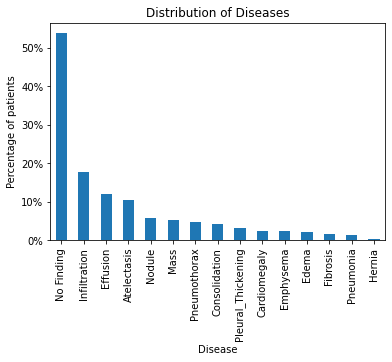

In [6]:
cases_df.plot(kind='bar')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Distribution of Diseases')
plt.xlabel('Disease')
plt.ylabel('Percentage of patients')
plt.show()

No Finding (53.84%) is the most common finding, followed by Infiltration (17.74%) and Effusion (11.87%).<br/>
The most uncommon finding is Hernia (0.20%), followed by Pneumonia (1.28%), the disease we want to detect.

## Distribution of diseases that are comorbid with pneumonia

In [7]:
pneumonia_df = all_xray_df[all_xray_df.Pneumonia == 1]
n_pneumonia = pneumonia_df.shape[0] + 0.
comorbities_count = dict()
for c_label in all_labels:
    if c_label == 'Pneumonia': continue
    comorbities_count[c_label] = pneumonia_df[pneumonia_df[c_label] == 1].shape[0] / n_pneumonia

comorbidities_df = pd.DataFrame({'Comorbidities of Pneumonia': list(comorbities_count.keys()), 'Correlation of comorbidity': list(comorbities_count.values())})
comorbidities_df.set_index('Comorbidities of Pneumonia', inplace = True)
comorbidities_df.sort_values(by = ['Correlation of comorbidity'], ascending = [False], inplace = True)
comorbidities_df

,Correlation of comorbidity
Comorbidities of Pneumonia,
Infiltration,0.422781
Edema,0.237596
Effusion,0.187980
Atelectasis,0.183089
Consolidation,0.085954
Mass,0.049616
Nodule,0.048917
Pleural_Thickening,0.033543
Cardiomegaly,0.028651


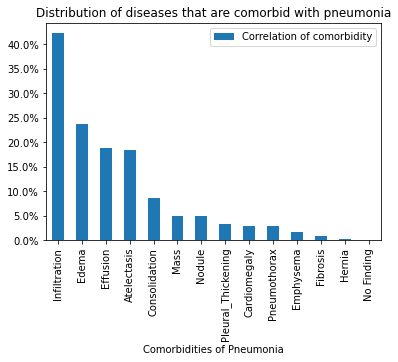

In [8]:
comorbidities_df.plot(kind='bar')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Distribution of diseases that are comorbid with pneumonia')
plt.show()

The most common comorbidities that accompany pneumonia are Infiltration (42.27%) and Edema (23.75%).<br/>
Given the high correlation of these diseases with Pneumonia, the datasets should be balanced regarding these correlations. Random sampling helps to alleviate this kind of biases.

## Pneumonia cases versus non-pneumonia cases

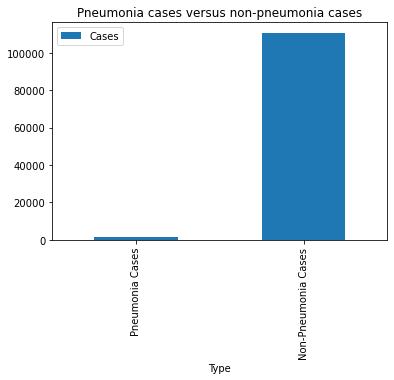

,Cases
Type,
Pneumonia Cases,1431.0
Non-Pneumonia Cases,110689.0


In [9]:
pneumonia_cases = pneumonia_df.shape[0]
non_pneumonia_cases = total_number - pneumonia_cases
pneumonia_stats_df = pd.DataFrame(data = {'Type':['Pneumonia Cases', 'Non-Pneumonia Cases'], 'Cases':[pneumonia_cases, non_pneumonia_cases]})
pneumonia_stats_df.set_index('Type', inplace = True)
pneumonia_stats_df.plot(kind='bar')
plt.title('Pneumonia cases versus non-pneumonia cases')
plt.show()
pneumonia_stats_df

Pneumonia cases are really rare, creating an unbalanced dataset.<br/>
Sampling should be done in a special way in order to overcome this unbalance.

## Number of diseases per patient

Population: 112120 patients.


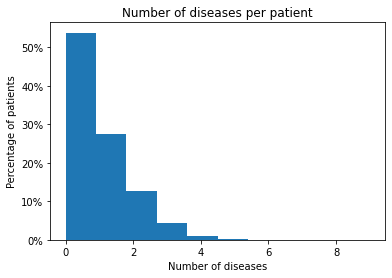

In [10]:
df = all_xray_df['Number of Diseases']
n = df.shape[0]
print(f'Population: {n} patients.')
plt.hist(df, weights = np.ones(n) / n)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Number of diseases per patient')
plt.xlabel('Number of diseases')
plt.ylabel('Percentage of patients')
plt.show()

Patients with no diseases are very common (53.84%) in this dataset.<br/>
Patients with 1 disease are almost 30% of the dataset.<br/>
Patients with 2 diseases are slightly above 10% of the dataset.<br/>
Patients with 3 diseases or more are rare.

## Histogram of ages of patients

In [11]:
def percent_hist(df):
    n = df.shape[0]
    print(f'Population: {n} patients.')
    plt.hist(df, weights = np.ones(n) / n)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.show()

Population: 112104 patients.


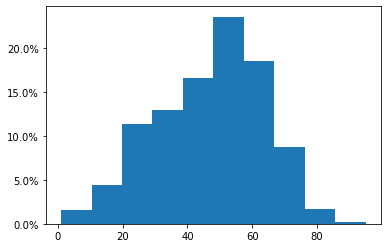

In [12]:
age_df = all_xray_df[all_xray_df['Patient Age'] < 130]['Patient Age']
percent_hist(age_df)

Patients in their 50s are the most common type of patient in this dataset.

## Histogram of ages of patients with pneumonia

Population: 1430 patients.


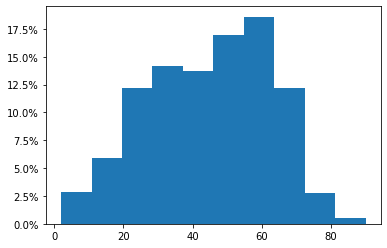

In [13]:
age_df = pneumonia_df[pneumonia_df['Patient Age'] < 130]['Patient Age']
percent_hist(age_df)

Patients with pneumonia tend to be in their 60s.

## Gender of patients

In [14]:
def gender_plot(df):
    n = df.shape[0]
    print(f'Population: {n} patients.')
    counts = df['Patient Gender'].value_counts() / n
    counts.plot(kind='bar') 
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.show()

Population: 112120 patients.


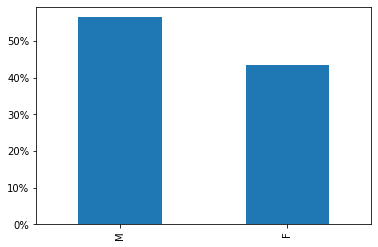

In [15]:
gender_plot(all_xray_df)

This dataset is slightly biased toward male patients.

## Gender of patients with pneumonia

Population: 1431 patients.


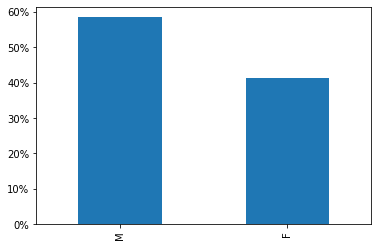

In [16]:
gender_plot(pneumonia_df)

Patients with pneumonia are more commonly male.

## Position of patients

In [17]:
def position_plot(df):
    n = df.shape[0]
    print(f'Population: {n} patients.')
    counts = df['View Position'].value_counts() / n
    counts.plot(kind='bar') 
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.show()

Population: 112120 patients.


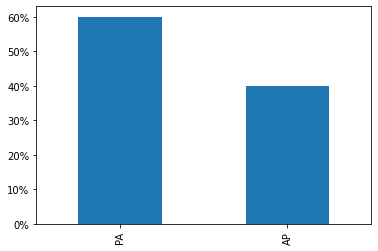

In [18]:
position_plot(all_xray_df)

In this dataset, the position PA is more common than AP.

## Position of patients with pneumonia

Population: 1431 patients.


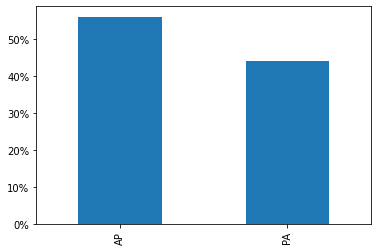

In [19]:
position_plot(pneumonia_df)

Among patients with pneumonia, the position AP is more common than PA.

## Number of follow-ups of patients

In [20]:
def percent_hist_follow_ups(df):
    n = df.shape[0]
    print(f'Population: {n} patients.')
    plt.hist(df, weights = np.ones(n) / n, bins = 40)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.show()

Population: 112120 patients.


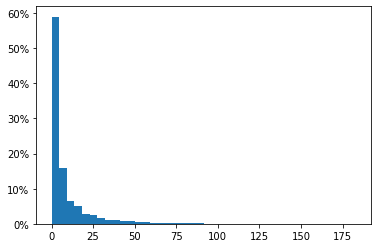

In [21]:
follow_up_df = all_xray_df['Follow-up #']
percent_hist_follow_ups(follow_up_df)

In this dataset, most patients have few follow-ups.

## Number of follow-ups of patients with pneumonia

Population: 1431 patients.


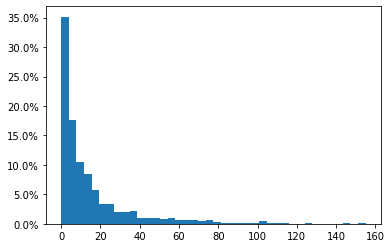

In [22]:
follow_up_df = pneumonia_df['Follow-up #']
percent_hist_follow_ups(follow_up_df)

Patients with pneumonia have few follow-ups.

# Pixel-level data

In [23]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
print(f'Number of entries: {sample_df.shape[0]}')
sample_df.sample(5)

Number of entries: 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3855,00018997_001.png,No Finding,1,18997,057Y,F,AP,2500,2048,0.168,0.168
3827,00018829_018.png,Pleural_Thickening,18,18829,055Y,M,AP,2500,2048,0.168,0.168
649,00003381_001.png,Atelectasis|Infiltration,1,3381,053Y,F,AP,3056,2544,0.139,0.139
2961,00014571_002.png,Infiltration,2,14571,078Y,M,PA,2500,2048,0.168,0.168
3182,00015650_000.png,Edema,0,15650,014Y,F,AP,2500,2048,0.168,0.168


In [24]:
all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [25]:
for c_label in all_labels:
    sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
sample_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
3337,00016493_003.png,Effusion|Infiltration,3,16493,007Y,F,PA,2726,2185,0.143,...,0,0,0,1,0,0,0,0,0,0
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139,...,0,0,0,0,0,1,0,0,0,0
4029,00019860_000.png,No Finding,0,19860,054Y,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
4462,00022208_010.png,Infiltration,10,22208,050Y,M,PA,2992,2991,0.143,...,0,0,0,1,0,0,0,0,0,0
2130,00010973_008.png,Effusion,8,10973,076Y,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0


In [26]:
def find_image(image_file):
    for suffix in range(1, 13):
        zeros = '00' if suffix < 10 else '0'
        path = f'/data/images_{zeros}{suffix}/images'
        image_path = f'{path}/{image_file}'
        if os.path.exists(image_path): return image_path
    return None

def read_image(df, index):
    image_file = find_image(df.loc[index]['Image Index'])
    image = plt.imread(image_file)
    return image

def show_image(image):
    plt.imshow(image, cmap = plt.get_cmap('gray'))
    plt.show()

In [27]:
def compute_stats(image):
    data = image.ravel()
    mean = np.mean(data)
    std = np.std(data)
    return mean, std

def histogram_of_pixel_intensities(row, image):
    data = image.ravel()
    mean, std = compute_stats(image)
    print(f'Pixel intensities betwen [0,1]: mean={mean:.4f}, std={std:.4f}')
    n_bins = 20
    n = data.shape[0]
    for x in [mean - std, mean, mean + std]:
        plt.axvline(x = x, color = 'r', linestyle = 'dashed', linewidth = 2)
    plt.hist(data, weights = np.ones(n) / n, bins = n_bins)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.title('Histogram of pixel intensities')
    plt.xlabel('Pixel intensities')
    plt.ylabel('Frequencies')
    plt.show()

def show_patient(df, i):
    row = df.iloc[i]
    index = row.name
    filename = row['Image Index']
    labels = row['Finding Labels']
    print(f'Name: {index}, Image index: {filename}, Finding Labels: {labels}')
    follow_up = row['Follow-up #']
    patient_id = row['Patient ID']
    patient_age = row['Patient Age']
    patient_gender = row['Patient Gender']
    view_position = row['View Position']
    print(f'Follow-up #{follow_up}, Patient ID: {patient_id}, Patient Age: {patient_age}, Patient Gender: {patient_gender}, View Position: {view_position}')
    image = read_image(df, index)
    show_image(image)
    histogram_of_pixel_intensities(row, image)

In [28]:
def compute_pixel_intensity_stats(df, i):
    row = df.iloc[i]
    index = row.name
    image = read_image(df, index)
    return compute_stats(image)

def compute_all_pixel_intensity_stats(df):
    n = df.shape[0]
    mean_sum = 0.
    std_sum = 0.
    for i in range(n):
        mean, std = compute_pixel_intensity_stats(df, i)
        mean_sum += mean
        std_sum += std
    return mean_sum / n, std_sum / n

def show_pixel_intensity_stats(df, title):
    avg_mean, avg_std = compute_all_pixel_intensity_stats(df)
    print(title)
    print('Statistics of pixel intensities:')
    print(f'avg_mean={avg_mean:.4f}, avg_std={avg_std:.4f}')

## Patients with no findings

In [29]:
no_finding_df = sample_df[sample_df['Finding Labels'] == 'No Finding']
no_finding_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,...,0,0,0,0,0,1,0,0,0,0
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,...,0,0,0,0,0,1,0,0,0,0


Name: 2, Image index: 00000017_001.png, Finding Labels: No Finding
Follow-up #1, Patient ID: 17, Patient Age: 077Y, Patient Gender: M, View Position: AP


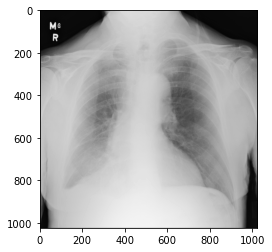

Pixel intensities betwen [0,1]: mean=0.6131, std=0.2194


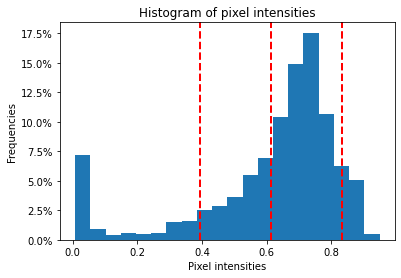

In [30]:
show_patient(no_finding_df, 0)

Name: 6, Image index: 00000042_002.png, Finding Labels: No Finding
Follow-up #2, Patient ID: 42, Patient Age: 071Y, Patient Gender: M, View Position: AP


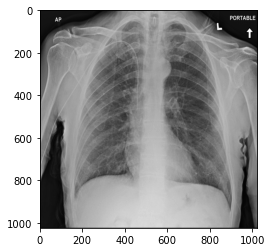

Pixel intensities betwen [0,1]: mean=0.4945, std=0.2051


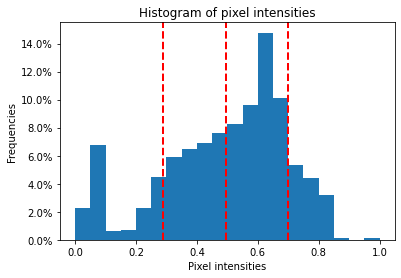

In [31]:
show_patient(no_finding_df, 1)

Name: 7, Image index: 00000057_001.png, Finding Labels: No Finding
Follow-up #1, Patient ID: 57, Patient Age: 071Y, Patient Gender: M, View Position: AP


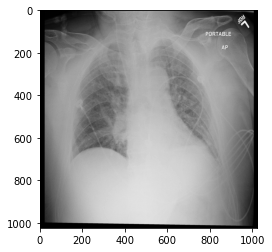

Pixel intensities betwen [0,1]: mean=0.5509, std=0.2233


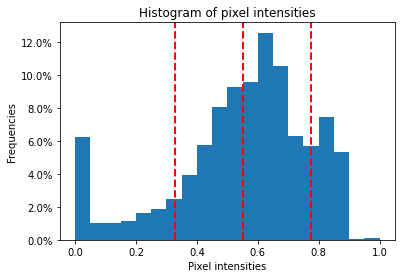

In [32]:
show_patient(no_finding_df, 2)

In [33]:
show_pixel_intensity_stats(no_finding_df, 'Patients with no findings')

Patients with no findings
Statistics of pixel intensities:
avg_mean=0.5073, avg_std=0.2298


### In patients with no findings, lungs are clear and images are brighter.

## Patients with pneumonia only

In [34]:
only_pneumonia_df = sample_df[sample_df['Finding Labels'] == 'Pneumonia']
only_pneumonia_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1631,00008470_008.png,Pneumonia,8,8470,030Y,F,AP,2500,2048,0.171,...,0,0,0,0,0,0,0,0,1,0
2286,00011702_043.png,Pneumonia,43,11702,026Y,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,1,0
2422,00012158_025.png,Pneumonia,25,12158,047Y,F,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,1,0


Name: 1631, Image index: 00008470_008.png, Finding Labels: Pneumonia
Follow-up #8, Patient ID: 8470, Patient Age: 030Y, Patient Gender: F, View Position: AP


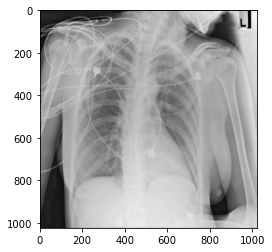

Pixel intensities betwen [0,1]: mean=0.5546, std=0.1714


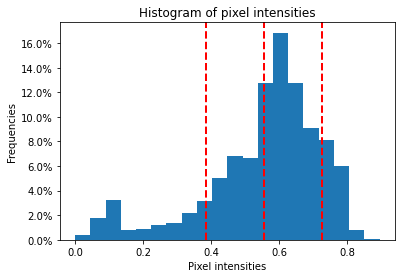

In [35]:
show_patient(only_pneumonia_df, 0)

Name: 2286, Image index: 00011702_043.png, Finding Labels: Pneumonia
Follow-up #43, Patient ID: 11702, Patient Age: 026Y, Patient Gender: F, View Position: AP


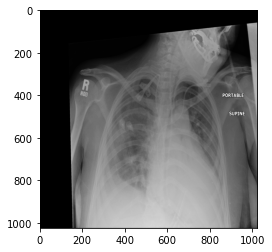

Pixel intensities betwen [0,1]: mean=0.3459, std=0.2555


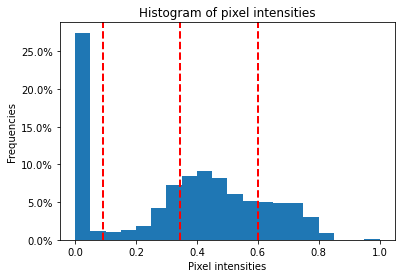

In [36]:
show_patient(only_pneumonia_df, 1)

Name: 2422, Image index: 00012158_025.png, Finding Labels: Pneumonia
Follow-up #25, Patient ID: 12158, Patient Age: 047Y, Patient Gender: F, View Position: PA


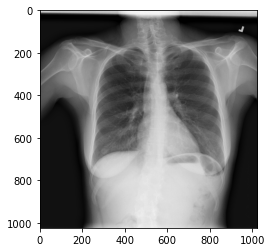

Pixel intensities betwen [0,1]: mean=0.4200, std=0.2815


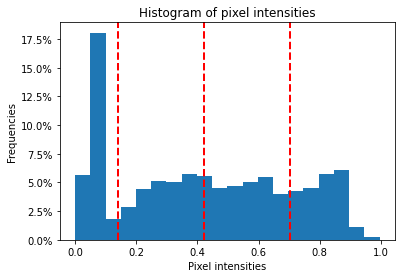

In [37]:
show_patient(only_pneumonia_df, 2)

In [38]:
show_pixel_intensity_stats(only_pneumonia_df, 'Patients with pneumonia only')

Patients with pneumonia only
Statistics of pixel intensities:
avg_mean=0.4606, avg_std=0.2478


### Patients with pneumonia tend to be structurally weaker and thinner, just an observation.

## Patients with pneumonia and infiltration

In [39]:
pneumonia_and_infiltration_df = sample_df[sample_df.Pneumonia == 1][sample_df.Infiltration == 1]
pneumonia_and_infiltration_df.head(3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
287,00001529_004.png,Consolidation|Infiltration|Pneumonia,4,1529,054Y,F,PA,2992,2991,0.143,...,0,0,0,1,0,0,0,0,1,0
382,00001993_000.png,Infiltration|Nodule|Pneumonia,0,1993,011Y,F,PA,2048,2500,0.168,...,0,0,0,1,0,0,1,0,1,0
1871,00009863_007.png,Atelectasis|Consolidation|Edema|Infiltration|P...,7,9863,040Y,F,AP,2500,2048,0.168,...,0,0,0,1,0,0,0,0,1,0


Name: 287, Image index: 00001529_004.png, Finding Labels: Consolidation|Infiltration|Pneumonia
Follow-up #4, Patient ID: 1529, Patient Age: 054Y, Patient Gender: F, View Position: PA


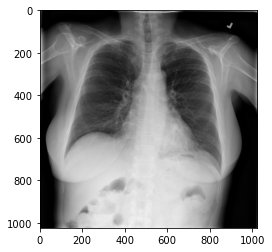

Pixel intensities betwen [0,1]: mean=0.4504, std=0.2919


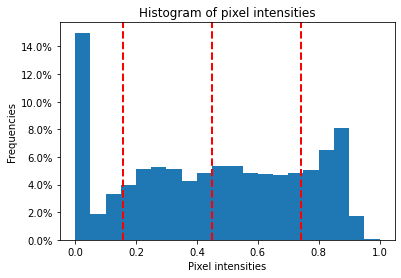

In [40]:
show_patient(pneumonia_and_infiltration_df, 0)

Name: 382, Image index: 00001993_000.png, Finding Labels: Infiltration|Nodule|Pneumonia
Follow-up #0, Patient ID: 1993, Patient Age: 011Y, Patient Gender: F, View Position: PA


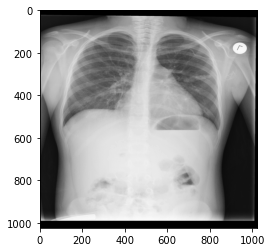

Pixel intensities betwen [0,1]: mean=0.5341, std=0.2950


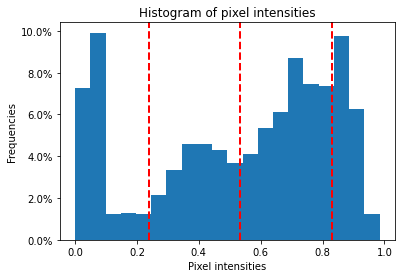

In [41]:
show_patient(pneumonia_and_infiltration_df, 1)

Name: 1871, Image index: 00009863_007.png, Finding Labels: Atelectasis|Consolidation|Edema|Infiltration|Pneumonia
Follow-up #7, Patient ID: 9863, Patient Age: 040Y, Patient Gender: F, View Position: AP


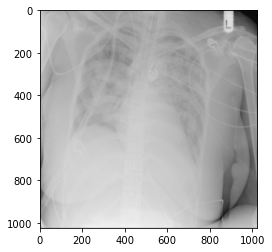

Pixel intensities betwen [0,1]: mean=0.6468, std=0.1190


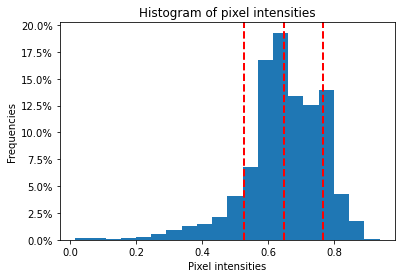

In [42]:
show_patient(pneumonia_and_infiltration_df, 2)

In [43]:
show_pixel_intensity_stats(pneumonia_and_infiltration_df, 'Patients with pneumonia and infiltration')

Patients with pneumonia and infiltration
Statistics of pixel intensities:
avg_mean=0.4672, avg_std=0.2336


### Patients with pneumonia and infiltration are similar to patients with pneumonia only. But they show mucus at the bottom of their lungs.

## Comparison across diagnoses

```
Patients with no findings
Statistics of pixel intensities:
avg_mean=0.5073, avg_std=0.2298

Patients with pneumonia only
Statistics of pixel intensities:
avg_mean=0.4606, avg_std=0.2478

Patients with pneumonia and infiltration
Statistics of pixel intensities:
avg_mean=0.4672, avg_std=0.2336
```

Patients with no findings have brighter images.
Patients with pneumonia only and patients with pneumonia and infiltration have similar brightness.
Variabilities in the pixel intensities are similar among the 3 types studied.